In [1]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np

import imprint as ip
from imprint.models.ttest_adaptive import TTest1DAda

2023-03-31 13:00:32,207 - imprint - DEBUG 
Enabling 64-bit floats in JAX.


In [2]:
mu_0 = 0  # fixed threshold for null hypothesis
theta_min = [-0.2, -1]  # minimum for theta
theta_max = [0, -0.1]  # maximum for theta
n_init = 100  # initial number of Gaussian draws
n_samples_per_interim = 50  # number of Gaussian draws per interim
n_interims = 3  # number of interims
n_gridpts = [200, 200]  # number of grid-points along each direction
alpha = 0.025  # target nominal level
n_sims = 8192  # number of simulations
eff_size_thresh = -jnp.inf

# try true critical threshold when 0 interims in the lambda space
df = n_init + n_interims * n_samples_per_interim - 1
lam = -scipy.stats.t.isf(alpha, df=df)

In [3]:
grid = ip.cartesian_grid(
    theta_min=theta_min,
    theta_max=theta_max,
    n=n_gridpts,
    null_hypos=[ip.hypo(f"theta0 <= {-2 * mu_0} * theta1")],
)

In [4]:
rej_df = ip.validate(
    TTest1DAda,
    g=grid,
    lam=lam,
    K=n_sims,
    model_kwargs={
        "n_init": n_init,
        "n_samples_per_interim": n_samples_per_interim,
        "n_interims": n_interims,
        "mu0": mu_0,
        "eff_size_thresh": eff_size_thresh,
    },
)
rej_df.tail()

,tie_sum,tie_est,tie_cp_bound,tie_bound,K
39995,392,0.047852,0.053621,0.098498,8192
39996,411,0.050171,0.056064,0.102449,8192
39997,434,0.052979,0.059016,0.107193,8192
39998,465,0.056763,0.062988,0.113524,8192
39999,490,0.059814,0.066186,0.118580,8192


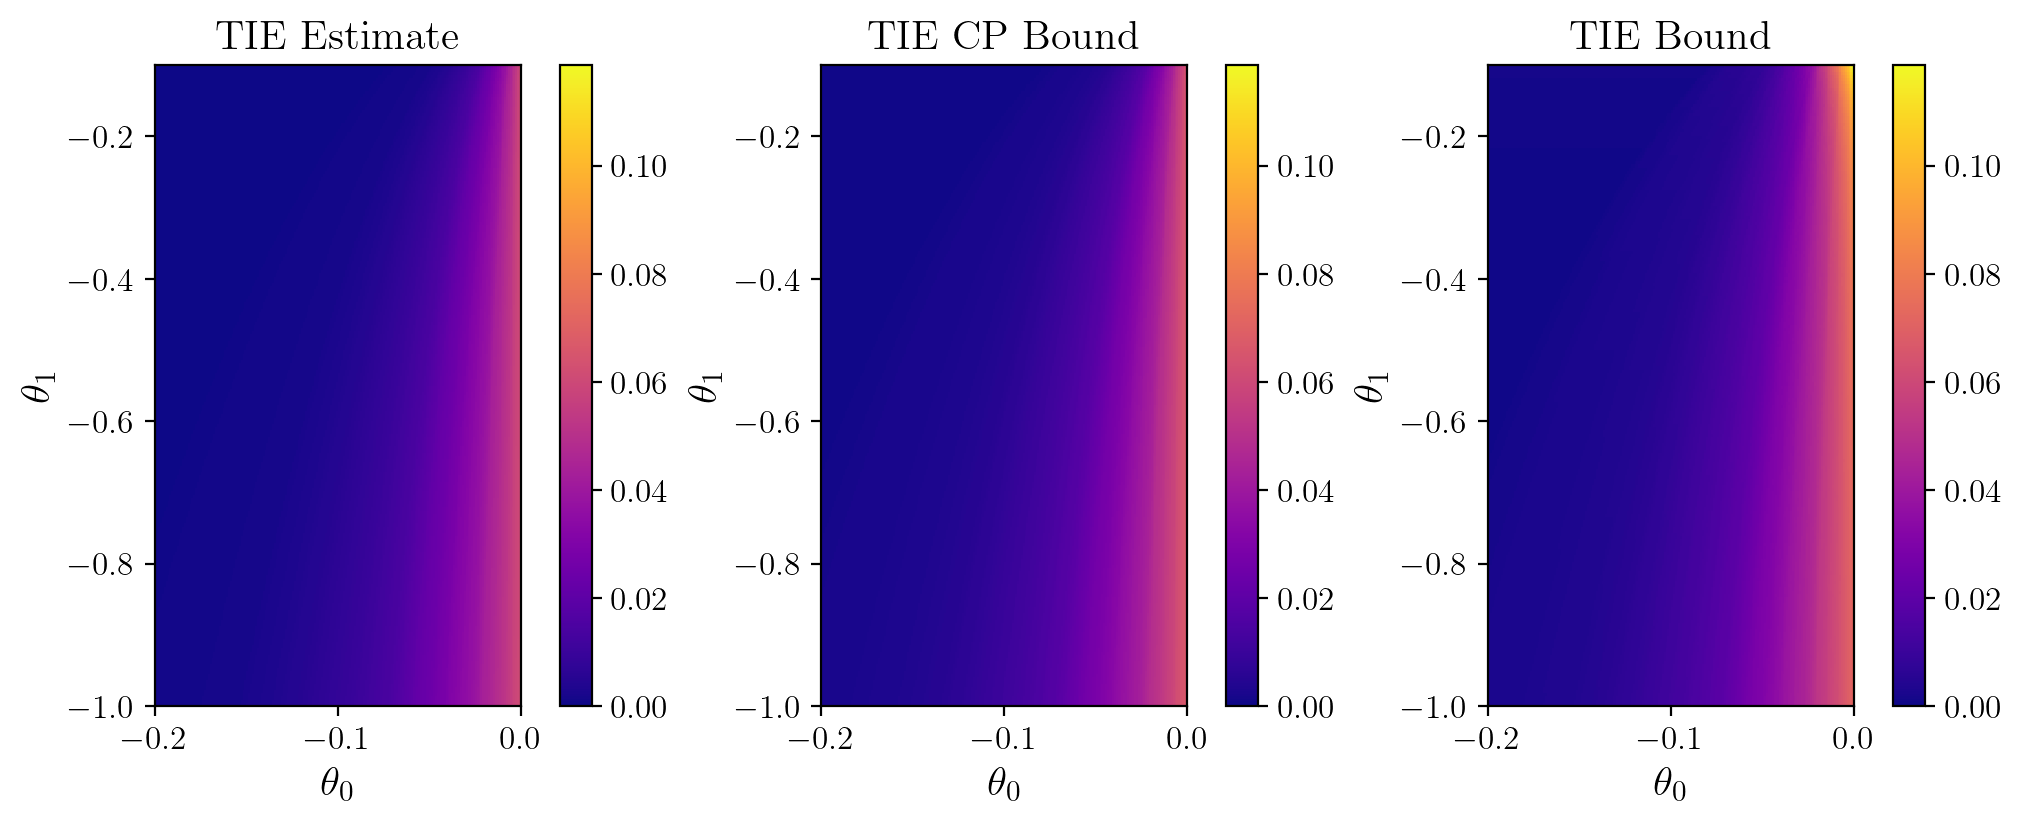

In [5]:
s = 3
names = ["tie_est", "tie_cp_bound", "tie_bound"]
titles = ["TIE Estimate", "TIE CP Bound", "TIE Bound"]
vmax = rej_df[names].max().max()
fig, axes = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
theta0s, theta1s = np.sort(np.unique(grid.df["theta0"])), np.sort(
    np.unique(grid.df["theta1"])
)
for i in range(3):
    ax = axes[i]
    title = titles[i]
    name = names[i]
    ax.set_title(title)
    sct = ax.pcolormesh(
        theta0s,
        theta1s,
        rej_df[name].to_numpy().reshape((theta0s.shape[0], theta1s.shape[0])),
        vmin=0,
        vmax=vmax,
    )
    ax.set_xlabel("$\\theta_0$")
    ax.set_ylabel("$\\theta_1$")
    fig.colorbar(sct, ax=ax)
plt.savefig("figures/t_test_adaptive.png")
plt.show()